<a href="https://colab.research.google.com/github/fardil-b/DL-PyTorch/blob/main/MNIST_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

# Import necessary packages

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch

import helper

import matplotlib.pyplot as plt


## Download the MNIST dataset through the torchvision package

In [3]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw




Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Check the data 

In [4]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


We can see that images is just a tensor with size (64, 1, 28, 28). So, 64 images per batch, 1 color channel, and 28x28 images.

Viewing one of the image

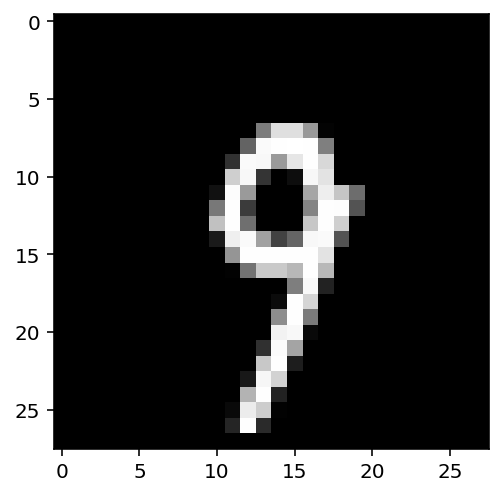

In [9]:
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');


First, let's try to build a simple network for this dataset using weight matrices and matrix multiplications. Then, we'll see how to do it using PyTorch's nn module which provides a much more convenient and powerful method for defining network architectures.

The networks you've seen so far are called fully-connected or dense networks. Each unit in one layer is connected to each unit in the next layer. In fully-connected networks, the input to each layer must be a one-dimensional vector (which can be stacked into a 2D tensor as a batch of multiple examples). However, our images are 28x28 2D tensors, so we need to convert them into 1D vectors. Thinking about sizes, we need to convert the batch of images with shape (64, 1, 28, 28) to a have a shape of (64, 784), 784 is 28 times 28. This is typically called flattening, we flattened the 2D images into 1D vectors.

Here we need to built a network with 10 output units, one for each digit. We want our network to predict the digit shown in an image, so what we'll do is calculate probabilities that the image is of any one digit or class. This ends up being a discrete probability distribution over the classes (digits) that tells us the most likely class for the image. That means we need 10 output units for the 10 classes (digits).

Flatten the batch of images images. Then build a multi-layer network with 784 input units, 256 hidden units, and 10 output units using random tensors for the weights and biases. For now, we use a sigmoid activation for the hidden layer. 

In [10]:
def activation(x):
    return 1/(1+torch.exp(-x))

# Flatten the input images
inputs = images.view(images.shape[0], -1) # -1 last element = 784

# Create parameters
w1 = torch.randn(784, 256)
b1 = torch.randn(256)

w2 = torch.randn(256, 10)
b2 = torch.randn(10)

h = activation(torch.mm(inputs, w1) + b1)

out = torch.mm(h, w2) + b2


Now we have 10 outputs for our network. We want to pass in an image to our network and get out a probability distribution over the classes that tells us the likely class(es) the image belongs to

Here we see that the probability for each class is roughly the same. This is representing an untrained network, it hasn't seen any data yet so it just returns a uniform distribution with equal probabilities for each class.

To calculate this probability distribution, we often use the softmax function. Mathematically this looks like

$$
\Large \sigma(x_i) = \cfrac{e^{x_i}}{\sum_k^K{e^{x_k}}}
$$

What this does is squish each input $x_i$ between 0 and 1 and normalizes the values to give you a proper probability distribution where the probabilites sum up to one.



 Implemention of a function softmax that performs the softmax calculation and returns probability distributions for each example in the batch. Note that you'll need to pay attention to the shapes when doing this. If you have a tensor a with shape (64, 10) and a tensor b with shape (64,), doing a/b will give you an error because PyTorch will try to do the division across the columns (called broadcasting) but you'll get a size mismatch. The way to think about this is for each of the 64 examples, you only want to divide by one value, the sum in the denominator. So you need b to have a shape of (64, 1). This way PyTorch will divide the 10 values in each row of a by the one value in each row of b. Pay attention to how you take the sum as well. You'll need to define the dim keyword in torch.sum. Setting dim=0 takes the sum across the rows while dim=1 takes the sum across the columns.

In [11]:
def softmax(x):
    return torch.exp(x)/torch.sum(torch.exp(x), dim=1).view(-1, 1)

probabilities = softmax(out)

# Does it have the right shape? Should be (64, 10)
print(probabilities.shape)
# Does it sum to 1?
print(probabilities.sum(dim=1))

torch.Size([64, 10])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])


## Building networks with PyTorch
PyTorch provides a module nn that makes building networks much simpler. Here we'll build the same model as above with 784 inputs, 256 hidden units, 10 output units and a softmax output.

In [12]:
from torch import nn


In [13]:

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Inputs to hidden layer linear transformation
        self.hidden = nn.Linear(784, 256)
        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(256, 10)
        
        # Define sigmoid activation and softmax output 
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.output(x)
        x = self.softmax(x)
        
        return x

class Network(nn.Module):


In [15]:
# Create the network and look at it's text representation
model = Network()
model

Network(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)